In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn
import torchsummary
from torchvision import transforms
import time
from sklearn.metrics import classification_report

In [ ]:
label_data=np.loadtxt('/home/sumins/workspace/washout classification/min_slice/label_train.txt',dtype=int)
label_data=label_data.tolist()
label_datat=np.loadtxt('/home/sumins/workspace/washout classification/min_slice/label_test.txt',dtype=int)
label_datat=label_datat.tolist()

In [ ]:
data_path='/home/sumins/workspace/washout classification/min_slice/channel4_train.nii'
channel4=[]
total=nib.load(data_path).get_fdata()
totalslice=total.shape[0]  

for i in range(0,totalslice):
    channel4.append(total[i,:,:,:])


data_patht='/home/sumins/workspace/washout classification/min_slice/channel4_test.nii'
channel4t=[]
totalt=nib.load(data_patht).get_fdata()
totalslicet=totalt.shape[0]  

for i in range(0,totalslicet):
    channel4t.append(totalt[i,:,:,:])

In [ ]:
WINDOW_MAX = 200
WINDOW_MIN = 0
GLOBAL_PIXEL_MEAN = 0.1

class CustomDataset(Dataset): 
  def __init__(self,volume_list,all_labels,transforms=None):
    self.volume_list=volume_list
    self.all_labels=all_labels
    self.length=len(all_labels)
    self.transforms=transforms


  def __len__(self):
    return self.length


  def __getitem__(self, idx):
    npy=self.volume_list[idx]

    npy[npy > WINDOW_MAX] = WINDOW_MAX
    npy[npy < WINDOW_MIN] = WINDOW_MIN
    
    npy = (npy - WINDOW_MIN) / (WINDOW_MAX - WINDOW_MIN)
    
    
    npy=npy.astype(dtype='float32')
    if self.transforms is not None:
      npy=self.transforms(npy)
    
    return{'npy':npy,'label':self.all_labels[idx]}

In [ ]:
transforms_train = transforms.Compose([transforms.ToTensor()
                                       ])
transforms_test = transforms.Compose([transforms.ToTensor()
                                       ])


In [ ]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // r),
            nn.ReLU(),
            nn.Linear(in_channels // r, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1) 
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return x

In [ ]:
class Depthwise(nn.Module):
    def __init__(self, in_num, out_num, stride=1):
        super().__init__()
        
        self.depthwise=nn.Sequential(
            nn.Conv2d(in_num, out_num,3,stride=stride, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.seblock=SEBlock(out_num)
    
    def forward(self,x):
        x=self.depthwise(x)
        x=self.seblock(x)*x
        return x

In [ ]:
class CustomConvNet(nn.Module):
    def __init__(self):
        super().__init__() #상속받은 class에 접근하기 위함

        self.layer1 = Depthwise(4, 16) #흑백사진은 inp
        self.layer2 = Depthwise(16, 32)
        self.layer3 = Depthwise(32, 64)
        self.layer4 = Depthwise(64, 128)
        self.layer5 = Depthwise(128, 256)
        self.gap = self.global_avg_pool(256, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.gap(out)
        out = out.view(-1, 2)

        return out


    def global_avg_pool(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1,1)))
        
model=CustomConvNet()
torchsummary.summary(model.cuda(),input_size=(4,512,512),batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 16, 512, 512]             592
       BatchNorm2d-2          [4, 16, 512, 512]              32
         LeakyReLU-3          [4, 16, 512, 512]               0
         MaxPool2d-4          [4, 16, 256, 256]               0
 AdaptiveAvgPool2d-5              [4, 16, 1, 1]               0
            Linear-6                     [4, 1]              17
              ReLU-7                     [4, 1]               0
            Linear-8                    [4, 16]              32
           Sigmoid-9                    [4, 16]               0
          SEBlock-10              [4, 16, 1, 1]               0
        Depthwise-11          [4, 16, 256, 256]               0
           Conv2d-12          [4, 32, 256, 256]           4,640
      BatchNorm2d-13          [4, 32, 256, 256]              64
        LeakyReLU-14          [4, 32, 2

In [ ]:
hyper_param_epoch=200
hyper_param_batch=8
hyper_param_learning_rate=0.0001

In [ ]:
print(len(channel4))
print(len(channel4t))

1422
363


In [ ]:
train_dataset=CustomDataset(volume_list=channel4, all_labels=label_data,transforms=transforms_train)
train_loader = DataLoader(train_dataset, batch_size=hyper_param_batch, shuffle=True)
test_dataset=CustomDataset(volume_list=channel4t, all_labels=label_datat,transforms=transforms_train)
test_loader = DataLoader(test_dataset, batch_size=hyper_param_batch, shuffle=True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device,"/" ,torch.cuda.device_count())

custom_model=CustomConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=hyper_param_learning_rate)

cuda:0 / 8


In [ ]:
def validation_loss(model):
    model.eval()
    correct = 0
    total = 0
    total_loss=0
    True_pred=0
    for i_batch, item in enumerate(test_loader):
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
 
        outputs =model(npys)
        loss = criterion(outputs, labels)
        total_loss+=loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += len(labels)
        correct += (predicted == labels).sum().item()
        for k in predicted:
            if k==1:
                True_pred+=1
    model.train()    
     
    return total_loss/(i_batch+1),100 * correct / total, True_pred



In [ ]:
loss_value=1
start=time.time()
custom_model.train()
train_loss_history=[]
valid_loss_history=[]
val_loss=0
for e in range(hyper_param_epoch):
        correct=0
        total=0
        for i_batch, item in enumerate(train_loader):
                npys = item['npy'].to(device)
                labels = item['label'].to(device)
                #print(npys)
                # Forward pass
                outputs =custom_model(npys)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += len(labels)
                correct += (predicted == labels).sum().item()
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        val_loss,val_accuracy, True_predict=validation_loss(custom_model)
        print(True_predict)
        train_loss_history.append(loss.item())
        valid_loss_history.append(val_loss)
        print('Epoch [{}/{}],i_batch={} ,Train_Loss: {:.4f},Train_acc: {:.2f}Valid_loss: {:.4f}, Valid_acc: {:.2f}'
                                        .format(e + 1, hyper_param_epoch, i_batch+1, loss.item(), 100*correct/total,val_loss, val_accuracy))
        print("Time: {}sec".format(time.time()-start))
        start=time.time()
        if loss_value>val_loss:
                loss_value=val_loss
                torch.save({
                'epoch': e,
                'model_state_dict': custom_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
                }, '/home/sumins/workspace/washout classification/model_save/senet.pth')


363
Epoch [1/200],i_batch=178 ,Train_Loss: 0.5641,Train_acc: 71.87Valid_loss: 0.6215, Valid_acc: 71.63
Time: 350.700395822525sec
294
Epoch [2/200],i_batch=178 ,Train_Loss: 0.5545,Train_acc: 77.57Valid_loss: 0.6514, Valid_acc: 60.33
Time: 348.8514792919159sec
189
Epoch [3/200],i_batch=178 ,Train_Loss: 0.5923,Train_acc: 78.62Valid_loss: 0.6682, Valid_acc: 58.95
Time: 350.7568163871765sec
172
Epoch [4/200],i_batch=178 ,Train_Loss: 0.5554,Train_acc: 79.89Valid_loss: 0.6835, Valid_acc: 56.47
Time: 344.7390899658203sec
53
Epoch [5/200],i_batch=178 ,Train_Loss: 0.5611,Train_acc: 79.68Valid_loss: 0.7961, Valid_acc: 34.16
Time: 337.68876099586487sec
291
Epoch [6/200],i_batch=178 ,Train_Loss: 0.5161,Train_acc: 80.52Valid_loss: 0.6436, Valid_acc: 68.87
Time: 344.49024653434753sec
363
Epoch [7/200],i_batch=178 ,Train_Loss: 0.5622,Train_acc: 82.00Valid_loss: 0.6008, Valid_acc: 71.63
Time: 327.4645917415619sec
363
Epoch [8/200],i_batch=178 ,Train_Loss: 0.4693,Train_acc: 81.58Valid_loss: 0.5862, Vali

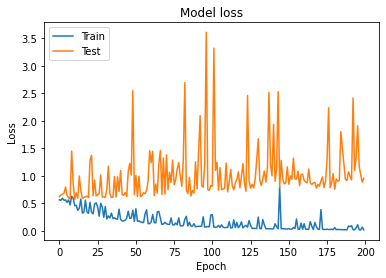

In [ ]:
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
import csv


with open("v_loss_senet.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(valid_loss_history)
with open("t_loss_senet.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(train_loss_history)

In [ ]:
true_label=[]
pred_label=[]

model=CustomConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)

checkpoint = torch.load('/home/sumins/workspace/washout classification/model_save/senet.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(epoch)
print(loss)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for item in test_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        
        outputs =model(npys)
        _, predicted = torch.max(outputs.data, 1)
        true_label.extend(labels)
        pred_label.extend(predicted)
        total += len(labels)
       
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

10
0.45676207542419434
Test Accuracy of the model on the 363 test images: 76.85950413223141 %


In [ ]:
true_labels=torch.tensor(true_label)
true_labels=true_labels.tolist()
pred_labels=torch.tensor(pred_label)
pred_labels=pred_labels.tolist()
print(classification_report(true_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.73      0.29      0.42       103
           1       0.77      0.96      0.86       260

    accuracy                           0.77       363
   macro avg       0.75      0.62      0.64       363
weighted avg       0.76      0.77      0.73       363



In [ ]:
num=0
for i in pred_label:
    if i==0:
        num+=1
print(num)

41


: 

In [ ]:
true_label=[]
pred_label=[]

model=CustomConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)

checkpoint = torch.load('/home/sumins/workspace/washout classification/model_save/model4.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(loss)
custom_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for item in train_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        
        outputs =model(npys)
        _, predicted = torch.max(outputs.data, 1)
        true_label.extend(labels)
        pred_label.extend(predicted)
        total += len(labels)
       
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

In [ ]:
true_labels=torch.tensor(true_label)
true_labels=true_labels.tolist()
pred_labels=torch.tensor(pred_label)
pred_labels=pred_labels.tolist()
print(classification_report(true_labels,pred_labels))